In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import numpy as np
from matplotlib import pyplot
from collections import OrderedDict
import cv2
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

trans = torchvision.transforms.Compose([torchvision.transforms.Resize(224), torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.QMNIST('~/Datasets/QMNIST', train=True, download=True, transform=trans)
test_data = torchvision.datasets.QMNIST('~/Datasets/QMNIST', train=False, download=True, transform=trans)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.01
epoch = 10
batch_size=100


train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=True)



loss = nn.CrossEntropyLoss()

# for feature, label in train_iter:
#     print(feature.shape)
#     print(label)
#     break

# 返回 shape: 100(batch_size) x 784 的 tensor
class FlattenLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # 原 shape [batch_size, 1, 28, 28] 返回 [batch_size, 784]
        return x.view(x.shape[0], -1)

num_outputs = 10


class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10)).to(device)

optim = torch.optim.SGD(net.parameters(), lr=lr)

# 查看每层处理结果形状
# X = torch.randn(1, 1, 224, 224)
# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__, 'output shape:\t', X.shape)


In [4]:
# 训练

for e in range(epoch):
    correct = 0
    total = 0
    for X, y in train_iter:
        X = X.cuda()
        y = y.cuda()
        y_pred = net(X)
        l = loss(y_pred, y).sum()
        l.backward()
        optim.step()
        optim.zero_grad()
        correct += (y_pred.argmax(dim=1) == y).float().sum()
        total += y.shape[0]
    test_acc = d2l.evaluate_accuracy(test_iter, net)
    print('[Epoch]', e)
    print('[Train accuracy]', (correct / total).item())
    print('[test accuracy]', test_acc)
    


[Epoch] 0
[Train accuracy] 0.11211666464805603
[test accuracy] 0.11318333333333333
[Epoch] 1
[Train accuracy] 0.11236666887998581
[test accuracy] 0.11318333333333333
[Epoch] 2
[Train accuracy] 0.36765000224113464
[test accuracy] 0.7980166666666667
[Epoch] 3
[Train accuracy] 0.9195166826248169
[test accuracy] 0.95985
[Epoch] 4
[Train accuracy] 0.959600031375885
[test accuracy] 0.9728833333333333
[Epoch] 5
[Train accuracy] 0.969783365726471
[test accuracy] 0.97845
[Epoch] 6
[Train accuracy] 0.9755333662033081
[test accuracy] 0.97835
[Epoch] 7
[Train accuracy] 0.9790666699409485
[test accuracy] 0.9824333333333334
[Epoch] 8
[Train accuracy] 0.9822333455085754
[test accuracy] 0.9836333333333334
[Epoch] 9
[Train accuracy] 0.9839333295822144
[test accuracy] 0.9848


(224, 224)
result is  8


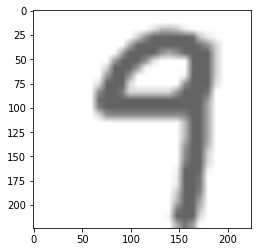

In [15]:
img = cv2.imread('./data/9.png', 0)

unloader = torchvision.transforms.ToPILImage()

# 把图片大小缩放为合适尺寸
r_img = cv2.resize(img, (224, 224))

print(r_img.shape) # (224, 224)

t_img = torchvision.transforms.functional.to_tensor(r_img).to(device)



pyplot.imshow(unloader(t_img), cmap="gray")


print('result is ', net(t_img.unsqueeze(0)).argmax().item())

shape torch.Size([1, 28, 28])
[num label]  0
[predict result] 0
/Users/float/opt/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  """Entry point for launching an IPython kernel.


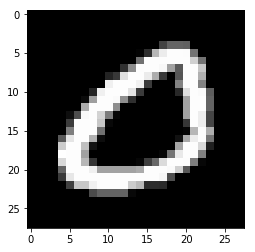

In [4]:
index = np.random.random_integers(0, 9999)
predict_label = test_data[index][1]
predict_data = test_data[index][0]


print('shape', predict_data.shape) # torch.Size([1, 28, 28])


pyplot.imshow(predict_data.view(28, 28), cmap="gray")

print('[num label] ', predict_label)
print('[predict result]', net(predict_data).argmax().item())